In [1]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

### Load Dataset

In [2]:
import datasets
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

# dataset = KarateClub()
print(dataset, '\n')
num_graph = len(dataset)
num_feature = dataset.num_features
num_node_feature = dataset.num_node_features
num_class = dataset.num_classes # node 커뮤니티 (군집) 에 해당함

num_graph, num_feature, num_node_feature, num_class

KarateClub() 



(1, 34, 34, 4)

In [3]:
data = dataset[0]  # 전체 데이터셋 첫번째 데이터를 받아오자.

print(data)
print('==============================================================')

# 그래프에 대한 다양한 통계를 확인하는 방법을 잘 알아두자.
print(f'노드 개수: {data.num_nodes}')
print(f'전체 edge 수: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
노드 개수: 34
전체 edge 수: 156
Average node degree: 9.18
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [4]:
data.train_mask # node 목록중에 train 으로 사용할 애만 binary 하게 표시되어 있는거임!

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [5]:
# data.y : 학습하고 싶은 대상 (타겟)
print(data.y) # 노드별 속한 label(community)에 대해 나오는듯 : 4종류니까 0,1,2,3
print(len(data.y))

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
34


In [6]:
data.y[data.train_mask]

tensor([1, 3, 0, 2])

In [7]:
# 엣지를 모두 출력해보자
# data.edge_index.T

각 그래프는 PyG의 그래프를 표현하기 위한 모든 정보를 가진 Data 클래스의 오브젝트이다. 우리는 간단히 출력을 통해서 언제든 이들의 요약된 정보를 확인할 수 있다.

데이터 오브젝트는 아래 4가지의 요소을 가진다.

- edge_index: 그래프의 연결 관계를 보여준다.
- node_features: 노드의 개별 feature vector를 보여준다.(여기서는 각 노드가 34차원의 feature vector를 갖는다)
- node_labels: 각 노드의 label을 가진다.
- train_mask: 훈련시 사용할 노드와 사용하지 않을 노드를 분류하기 위한 정보를 가진다.
- 또한, data 오브젝트는 유용한 함수들을 제공하는데, isolated node, self-loop 등을 확인할 수 있다.

In [8]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

Edge index

In [9]:
# edge 확인하기
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

- 2개의 노드를 가진 튜플로 이루어짐
- (출발점, 도착지점)
- 이러한 표현을 COO(coordinate) format으로 알려져 있고, sparse matrices를 표현하기 위해서 사용된다.
- 그리고 이것은 networkx형태로 바꾸어 시각화할 수 있다.

### Pyg Visualization

In [10]:
# 시각화를 위한 헬퍼함수를 작성한다.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# NX와 Pytorch tensor 모두를 시각화 할 수 있는 함수이다.
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    # 데이터가 pytorch일 경우
    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    # 데이터가 NX일 경우
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

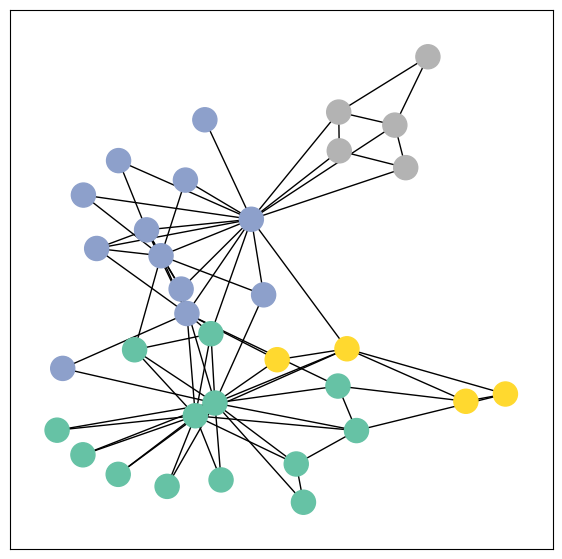

In [11]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

### Model Build
![explain](./explain.png)
- reference : https://velog.io/@djm0727/ML-with-Graph-Colab0#dataset

In [12]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        #### 각 층 별로 aggregate 하는거임. 여기선 3 hop (3 layer)로 설정
        self.conv1 = GCNConv(dataset.num_features, 4) # 34(노드 피쳐인듯?) => 4
        self.conv2 = GCNConv(4,4) # 왜 똑같이 하는건진 잘 모르겠음
        self.conv3 = GCNConv(4,2) # 왜 2인지 모르겠네 => 여기 걍 특정숫자로 다 똑같이 하는경우도 있음.. 일단 다 그냥 똑같은 값으로 한다고 생각해야될듯..?
        ####
        self.classifier = Linear(2, dataset.num_classes) # 노드 클래스 4개
    
    def forward(self, x, edge_index):
        # 위에서 설정한 것들에 대한 순서
        h = self.conv1(x, edge_index) # 여기있는 인자들은 무슨 의미인지
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        
        # final classifier (4개의 클래스에 맵핑)
        out = self.classifier(h)
        
        return out, h # out : class에 대한 one hot 일듯?, h : 노드임베드 함수일듯
    
model = GCN()
model
    

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

#### Visualize node embedding 
- 모델 가중치 학습 전 모델 정의만 한후에 노드 임베딩 공간 시각화
- 가중치가 랜덤으로 되어있지만 동일 색상(커뮤니티)의 노드들이 어느정도 이미 밀접하게 모여있음

##### 학습 전

In [13]:
model = GCN() # 학습이 아직 안된 모델을 객체로 불러온다

out, h = model(data.x, data.edge_index)
print(out.shape,'\n')
print(out)

torch.Size([34, 4]) 

tensor([[-0.1800,  0.6863,  0.1599,  0.1414],
        [-0.1946,  0.6587,  0.1327,  0.1069],
        [-0.1859,  0.6638,  0.1398,  0.1144],
        [-0.1890,  0.6638,  0.1388,  0.1139],
        [-0.1998,  0.6751,  0.1442,  0.1249],
        [-0.1905,  0.6825,  0.1533,  0.1352],
        [-0.1894,  0.6815,  0.1528,  0.1341],
        [-0.1931,  0.6610,  0.1351,  0.1099],
        [-0.1940,  0.6523,  0.1278,  0.0997],
        [-0.1952,  0.6484,  0.1243,  0.0950],
        [-0.1975,  0.6765,  0.1461,  0.1269],
        [-0.1835,  0.6835,  0.1564,  0.1376],
        [-0.1935,  0.6638,  0.1372,  0.1130],
        [-0.1913,  0.6574,  0.1328,  0.1060],
        [-0.2014,  0.6454,  0.1198,  0.0904],
        [-0.1991,  0.6445,  0.1198,  0.0898],
        [-0.1890,  0.6801,  0.1519,  0.1327],
        [-0.2028,  0.6605,  0.1315,  0.1076],
        [-0.1974,  0.6422,  0.1186,  0.0874],
        [-0.1994,  0.6531,  0.1267,  0.0997],
        [-0.1955,  0.6516,  0.1268,  0.0986],
        [-0.

Embedding shape: [34, 2]


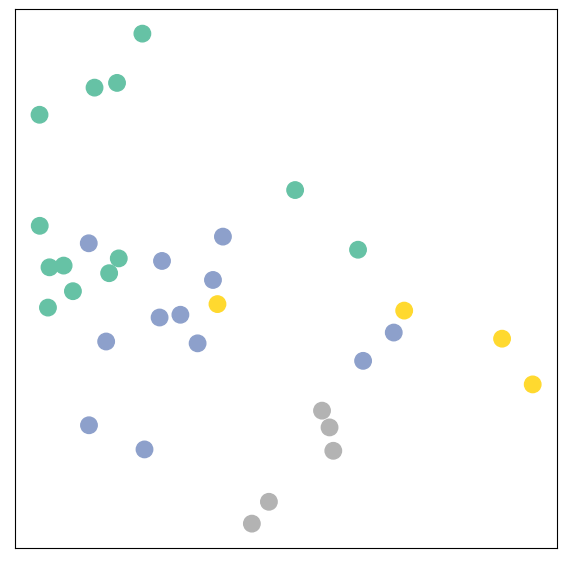

In [14]:
# model = GCN() # 학습이 아직 안된 모델을 객체로 불러온다

# _, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

### Train
모델의 모든 것이 차별화 및 매개 변수화 가능하기 때문에 일부 레이블을 추가하고 모델을 교육하며 임베딩이 어떻게 반응하는지 관찰할 수 있다. 여기서 우리는 준지도 또는 전이 학습을 사용한다. 클래스당 하나의 노드에 대해 간단히 훈련하지만 완전한 입력 그래프 데이터를 사용할 수 있다.

In [15]:
import time

model = GCN()
loss_func = torch.nn.CrossEntropyLoss()  # loss를 크로스 엔트로피로 정의.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 옵티마이저를 adam이용.

In [16]:
def train(data):
    optimizer.zero_grad()  # 그래디언트 초기화.
    out, h = model(data.x, data.edge_index)  # single forward.
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])  # 훈련 노드를 기반으로 loss 계산.
    loss.backward()  # 그래디언트의 계산.
    optimizer.step()  # 가중치 업데이트.

    accuracy = {}
    # training accuracy 정확도를 4개의 examples를 이용하여 계산
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # validation accuracy를 전체 그래프를 이용하여 계산
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

1번째 그림 (현재 epoch => 200)


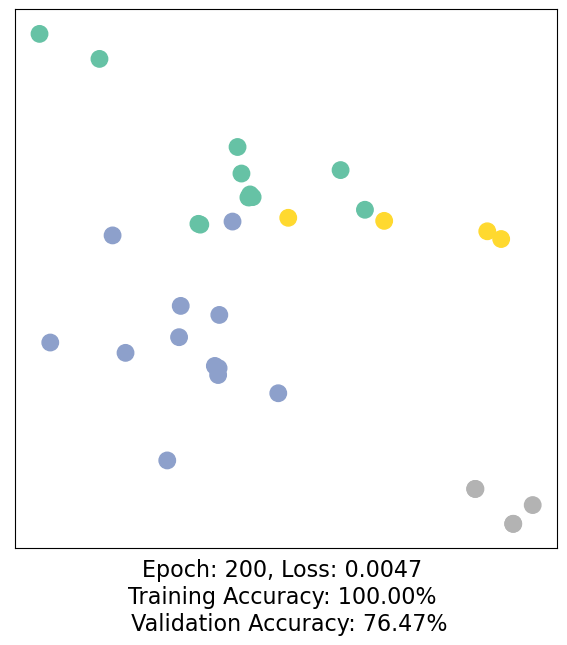

2번째 그림 (현재 epoch => 400)


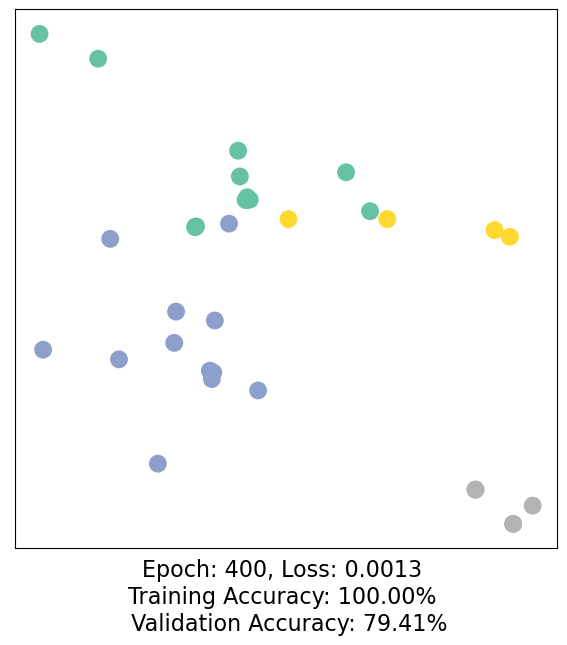

3번째 그림 (현재 epoch => 600)


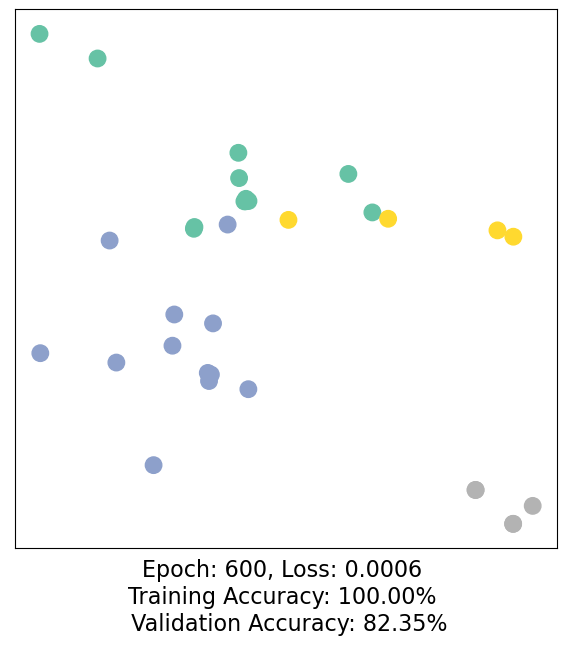

4번째 그림 (현재 epoch => 800)


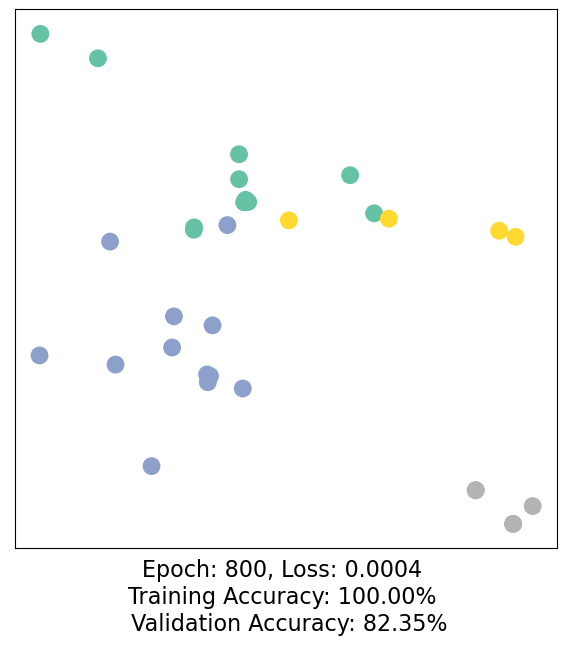

5번째 그림 (현재 epoch => 1000)


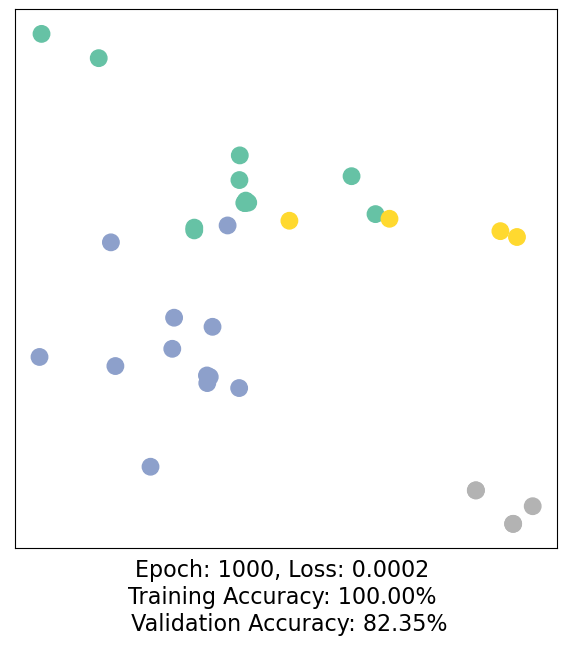

In [17]:
epoch_num = 1000
vis_cnt = 0

for epoch in range(1, epoch_num+1):
    loss, h, accuracy = train(data)
    
    # 200epochs마다 임베딩 시각화
    if epoch % 200 == 0:
        vis_cnt +=1
        print(f'{vis_cnt}번째 그림 (현재 epoch => {epoch})')
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)